# Forward Kinematics of the leg in 3D

The goal of today's laboratory will be to build functions to compute the forward kinematics of the robot and then to use these functions to measure the position of the end-effector when performing various tasks. Modeling kinematics is usually the first (or second) thing that one does when using a robot.

## Instructions
Answer all the questions below and submit a pdf with detailed answers to these questions, including the plots through Brightspace. You will also need to submit the Jupyter notebooks with the code implementing the forward kinematics algorithm


## Robot model
Consider the following kinematic model of the robot <img src="./3d_robot_model.png" width="700">

In [5]:
# we import useful libraries
import time
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

In [6]:
from NYUFinger.sim import NYUFingerSimulator

# Set this to true and restart the kernel to use the real robot
use_real_robot = False

if use_real_robot:
    from NYUFinger.real import NYUFingerHardware
    robot = NYUFingerHardware()
else:
    robot = NYUFingerSimulator()


ModuleNotFoundError: No module named 'mujoco'

## Question 1: creating our building blocks
The goal of this question is to build functionality for rigid body motions. Each motion can be decomposed in translations and rotations, so they are our basic building blocks to construct any homogenous transforms.
1. Write a ``translate(vector)`` function that takes a 3D numpy vector as an argument and returns an homogeneous transform corresponding to a translation in the direction of the input. 
2. Write ``rotateX(angle)``, ``rotateY(angle)`` and ``rotateZ(angle)`` functions that take an angle as an argument and return an homogeneous transform corresponding to a rotation of that angle around the X, Y or Z axes. Remember that these rotations can be computed as

$R_x(\theta) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & \cos\theta & -\sin\theta \\ 0 & \sin\theta & \cos\theta \end{bmatrix}\qquad$
$R_y(\theta) = \begin{bmatrix} \cos\theta & 0 & \sin\theta \\ 0 & 1 & 0 \\ -\sin\theta & 0 & \cos\theta \end{bmatrix}\qquad$
$R_z(\theta) = \begin{bmatrix} \cos\theta & -\sin\theta & 0 \\ \sin\theta & \cos\theta & 0 \\ 0 & 0 & 1 \end{bmatrix}$

You can use the code template below for the functions.

In [7]:

def translate(vector):
    # Initialize a 4x4 identity matrix, representing no transformation
    transform = np.eye(4)
    
    # Assign translation values to the last column
    transform[0][3] = vector[0]
    transform[1][3] = vector[1]
    transform[2][3] = vector[2]

    # Return the translation matrix
    return transform

def rotateX(angle):
    transform = np.eye(4)
    
    # Define the X-axis rotation matrix
    transform[1][1] = np.cos(angle)
    transform[1][2] = -np.sin(angle)
    transform[2][1] = np.sin(angle)  
    transform[2][2] = np.cos(angle)

    # Return the rotation matrix around the X-axis
    return transform

def rotateY(angle):
    transform = np.eye(4)
    
    # Define the Y-axis rotation matrix
    transform[0][0] = np.cos(angle)
    transform[0][2] = -np.sin(angle)
    transform[2][0] = np.sin(angle)
    transform[2][2] = np.cos(angle)
    
    # Return the rotation matrix around the Y-axis
    return transform

def rotateZ(angle):
    transform = np.eye(4)
    
    # Define the Z-axis rotation matrix
    transform[0][0] = np.cos(angle)
    transform[0][1] = -np.sin(angle)
    transform[1][0] = np.sin(angle)
    transform[1][1] = np.cos(angle)
    
    return transform


## Question 2: forward kinematics
Now we can use these series of transformation to compute the full forward kinematics for the end-effect, i.e. $T_{SF}$.
1. Use these functions to compute $T_{SH_1}$, $T_{SH_2}$, $T_{SK}$ and $T_{SF}$ when the angles $\theta_0$, $\theta_1$ and $\theta_2$ are given (in the report, also write the theoretical formulae using translations and rotations for these computations).
2. Write a function ``forward_kinematics(theta)`` that takes a vector of 3 angles as input (the 3 DOFs of the robot) and returns T_SF. You may use the function template below.
2. Verify that the function is working correctly by computing the position/orientation of the foot when 
    1. $\theta_0=\theta_1=\theta_2 = 0$ (the pose should be $\ T_{SF} = \begin{bmatrix} 1 & 0 & 0 & 0.3 \\ 0 & 1 & 0 & -0.32 \\ 0 & 0 & 1 & 0.014 \\ 0 & 0 & 0 & 1\end{bmatrix}$, 
    
    2. $\theta_0=-\frac{\pi}{2}$, $\theta_1 = \pi$ and $\theta_2 = -\frac{\pi}{2}$ (the pose should be $\ T_{SF} = \begin{bmatrix} 0 & -1 & 0 & 0.46 \\ 0 & 0 & 1 & 0.014 \\ -1 & 0 & 0 & -0.16 \\ 0 & 0 & 0 & 1\end{bmatrix}$

In [8]:
def forward_kinematics(theta):
    # assume theta is a vector, theta[0] = theta0, theta[1] = theta1, etc.
    # we define the lengths of the robot
    l0 = 0.3
    l1 = 0.16
    l2 = 0.16
    l3 = 0.014
    
    ###WRITE YOUR CODE HERE
    t_SH1 = translate([l0,0,0]) @ rotateX(theta[0]) 
    t_H1H2 = translate([0,0,l3]) @ rotateZ(theta[1])

    t_H2K = translate([0,-l1,0]) @ rotateZ(theta[2]) 

    t_KF = translate([0,-l2,0]) 
    
    t_SF = t_SH1 @ t_H1H2 @ t_H2K @ t_KF
    ### we return the object
    return t_SF

## Question 3: using forward kinematics to find the end-effector position
We are now ready to use the function to compute the movement of the end-effector. The following code runs a controller (in simulation or on the real robot) that follows a particular movement using a PD controller. There are two types of movements that can be selected by changing the variable "type_of_trajectory" to 0 or 1.

For each type of trajectory (0 or 1):
1. Use your forward_kinematics function in the following code to compute the position of the foot in frame {S} given by the sensor measurements during the movement of the robot (to be stored in the ``measured_foot_position`` variable) as well as the position that the foot would have in frame {S} given the desired joint positions (to be stored in ``desired_foot_position``). 
2. Plot the measured and desired motion of the foot in 2D and 3D using the function ``plot_foot_trajectory()`` below
3. What is the maximum and minimum height (y axis) reached by the foot during the movement? And the maximum/minimum width (along the z axis)?
4. Compare the desired and measured positions of the foot
5. Answer questions 1-4 again on the real robot

In [9]:
def generate_trajectory(t, type_of_trajectory):
    """
    This function generates two types of trajectories based on type_of_trajectory (0 or 1)
    it returns a 3D vector of desired positions and 3D vector of desired velocities based 
    on the time t (a real number) that indexes the trajectory
    """
    q_des = np.array([0.,0.,0.])
    dq_des = np.array([0.,0.,0.])
    
    if type_of_trajectory==0:
        q_des[1] = 0.4*np.cos(np.pi*t) + 0.7
        dq_des[1] = -0.4*np.pi*np.sin(np.pi*t)
        q_des[2] = -0.8*np.cos(np.pi*t) - 1.4
        dq_des[2] = 0.8*np.pi*np.sin(np.pi*t)
    elif type_of_trajectory==1:
        q_des[0] = 0.2*np.cos(2*np.pi*t) + 0.3
        dq_des[0] = -2*0.2*np.pi*np.sin(2*np.pi*t)
        q_des[1] = 0.4*np.cos(np.pi*t) + 0.6
        dq_des[1] = -0.4*np.pi*np.sin(np.pi*t)
        q_des[2] = -0.2*np.cos(2*np.pi*t+np.pi/4) - 1.4
        dq_des[2] = 2*0.2*np.pi*np.sin(2*np.pi*t+np.pi/4)
    return q_des, dq_des

## Real Robot?
If you're running the notebook on the real robot, first make sure you reset the sensors as you did in previous labs so the robot knows where it is. Specifically, first carefully move the robot's joints so that it looks like the following picture and then run the reset command in the next cell. If you're doing things in simulation, you don't need to worry about it.

![image.png](images/robot_home.png)

In [ ]:
robot.reset_sensors()

In [10]:
## This runs the main control loop - it has the same structure as the loop seen in the previous lab

# we select a type of trajectory (choose between 0 and 1)
type_of_trajectory = 1

# we reset the simulation
#if not use_real_robot:
#    robot.reset_state(generate_trajectory(0.,type_of_trajectory)[0])

# we simulate for 10 seconds
run_time = 10.
dt = 0.001
num_steps = int(run_time/dt)

# the PD gains
P = np.array([1.5, 1.5, 1.5])
D = np.array([0.01, 0.01, 0.01])*10


## we allocate a few vectors to collect data while we do the simulation
# we will store the sensor values (angular position and velocities)
measured_positions = np.zeros([num_steps,3])
measured_velocities = np.zeros_like(measured_positions)
# we will store the commands sent to the robot
desired_torques = np.zeros_like(measured_positions)
# we will store the desired joint trajectories that the PD controller follows
desired_positions = np.zeros_like(measured_positions)
desired_velocities = np.zeros_like(measured_positions)
# we keep track of time
t = np.zeros([num_steps])
# we will store the end effector position (desired and measured)
measured_foot_position = np.zeros([num_steps,3])
desired_foot_position = np.zeros([num_steps,3])


## this is our main control loop ##
## we do the loop for num_steps ##
for i in range(num_steps):
    # get the current time
    t[i] = dt * i
    
    # we read the position and velocities of the joints from the robot or simulation
    q, dq = robot.get_state()
    
    # we store these values for later use
    measured_positions[i,:] = q
    measured_velocities[i,:] = dq
    
    # we get the current desired positions and velocities from the trajectory generator
    q_des, dq_des = generate_trajectory(t[i], type_of_trajectory)
    
    desired_positions[i,:] = q_des
    desired_velocities[i,:] = dq_des
    
    #### TO ADD ####
    # compute the current foot position using the FK function
    # store this position in the current_foot_position variable
    #measured_foot_position[i] = forward_kinematics(measured_positions[q])[0:3,3]
    measured_foot_position[i] = forward_kinematics(q)[:3, 3]
    # compute the desired foot position using the FK function
    # store this position in the desired_foot_position variable
    #desired_foot_position[i] = forward_kinematics(desired_positions[dq])[0:3,3]
    desired_foot_position[i] = forward_kinematics(q_des)[:3, 3]
    # the rest of the loop gets the desired trajectory and tracks it with a PD controller
    # you may need to tune the PD gains for the real robot to get good tracking 
    # (use the gains you found in the previous lab)
    
    
    error = q_des - q # the position error for all the joints (it's a 3D vector)
    d_error = dq_des-dq # the velocity error for all the joints
    
    # we compute the desired torques as a PD controller
    joint_torques = P * error + D * d_error
    desired_torques[i,:] = joint_torques
    
    # we send them to the robot and do one simulation step
    robot.send_joint_torque(joint_torques)
    time.sleep(dt)  

NameError: name 'robot' is not defined

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


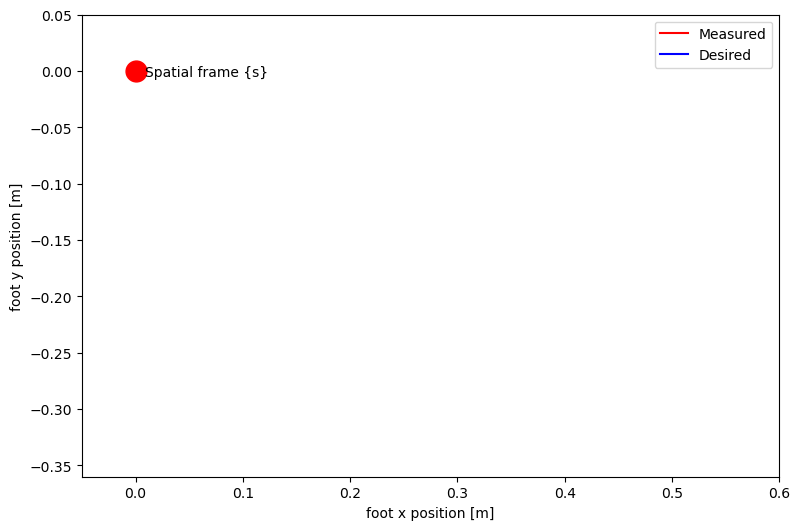

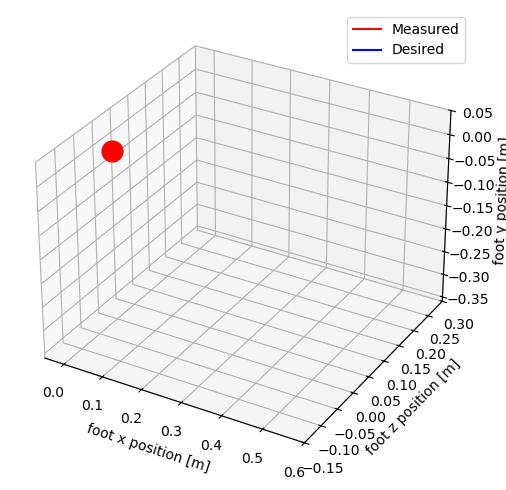

In [11]:
def plot_foot_trajectory(measured_foot_position, desired_foot_position):
    """
    plots the position of the foot in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """
    fig = plt.figure(figsize=[9,6])
    ax = fig.add_subplot(111)
    plt.plot(measured_foot_position[:,0],measured_foot_position[:,1], 'r', label='Measured')
    plt.plot(desired_foot_position[:,0],desired_foot_position[:,1], 'b', label='Desired')
    plt.xlabel('foot x position [m]')
    plt.ylabel('foot y position [m]')
    plt.xlim([-0.05,0.6])
    plt.ylim([-0.36, 0.05])
    plt.plot([0],[0],'o',markersize=15,color='r')
    ax.annotate('Spatial frame {s}', xy=(-0.03,-0.005), xytext=(30,0), textcoords='offset points')
    plt.legend()
    
    fig = plt.figure(figsize=[9,6])
    ax = fig.add_subplot(111, projection='3d')
    ax.plot3D(measured_foot_position[:,0],measured_foot_position[:,2], measured_foot_position[:,1], 'r', label='Measured')
    ax.plot3D(desired_foot_position[:,0],desired_foot_position[:,2], desired_foot_position[:,1], 'b', label='Desired')
    ax.set_xlabel('foot x position [m]')
    ax.set_zlabel('foot y position [m]')
    ax.set_ylabel('foot z position [m]')
    ax.set_xlim([-0.05,0.6])
    ax.set_zlim([-0.36, 0.05])
    ax.set_ylim([-0.15, 0.3])
    ax.plot3D([0],[0],[0],'o',markersize=15,color='r')
    ax.legend()
    
print(measured_foot_position)
print(desired_foot_position)
# you need to first create x_pos and y_pos variables!    
plot_foot_trajectory(measured_foot_position, desired_foot_position)

In [ ]:

# Compute max and min heights (y-axis) and widths (z-axis) for measured positions
max_height_measured = np.max(measured_foot_position[:, 1])
min_height_measured = np.min(measured_foot_position[:, 1])
max_width_measured = np.max(measured_foot_position[:, 2])
min_width_measured = np.min(measured_foot_position[:, 2])

print(f"Max Height (Y) of Measured: {max_height_measured}")
print(f"Min Height (Y) of Measured: {min_height_measured}")
print(f"Max Width (Z) of Measured: {max_width_measured}")
print(f"Min Width (Z) of Measured: {min_width_measured}\n")

# Compute max and min heights (y-axis) and widths (z-axis) for desired positions
max_height_desired = np.max(desired_foot_position[:, 1])
min_height_desired = np.min(desired_foot_position[:, 1])
max_width_desired = np.max(desired_foot_position[:, 2])
min_width_desired = np.min(desired_foot_position[:, 2])

print(f"Max Height (Y) of Desired: {max_height_desired}")
print(f"Min Height (Y) of Desired: {min_height_desired}")
print(f"Max Width (Z) of Desired: {max_width_desired}")
print(f"Min Width (Z) of Desired: {min_width_desired}\n")

# Compare desired and measured positions
position_difference = np.linalg.norm(measured_foot_position - desired_foot_position, axis=1)

print(f"Average Difference in Position: {np.mean(position_difference)}")
print(f"Largest Difference in Position: {np.max(position_difference)}")
